<a href="https://colab.research.google.com/github/arkadijshmelev/predict_numbers/blob/master/Tensorflow_predicts_numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Библиотеки

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


### Настройки

In [3]:
# Проверяем что у нас работает GPU.
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
# Имя графического поцессора.
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-dd493fb1-f0ef-6457-d4ea-93474617dc92)


In [5]:
# Используем эту команду, чтобы увидеть активность графического
# процессора при выполнении задач глубокого обучения.
!nvidia-smi

Wed Aug  9 11:45:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W /  70W |    387MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Данные

In [6]:
# Скачиваем данные.
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [7]:
# Посмотрим на данные.
print(x_train.shape)
print(x_val.shape)
print(y_train[:10])
print(y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


#### Статья по компьтерному зрению:

https://habr.com/ru/companies/ruvds/articles/682462/

Пример кусочка картинки (пиксели со значениями от 0 до 255):


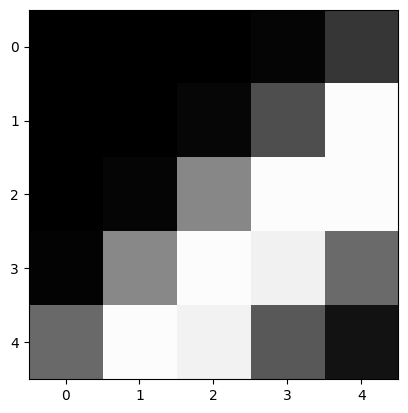

Пример картинки:


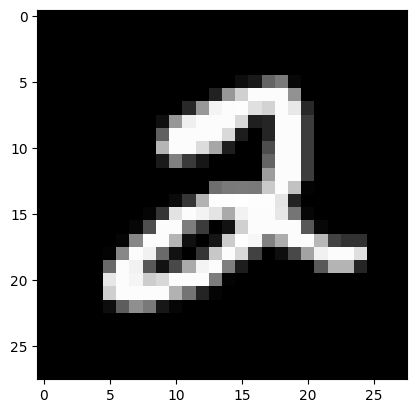

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [8]:
# Нарисуем картинку.
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print('Пример картинки:')
plt.imshow(x_train_image, cmap='Greys')
plt.show()
print('y_train [shape %s] 10 примеров:\n' % (str(y_train.shape)), y_train[:10])

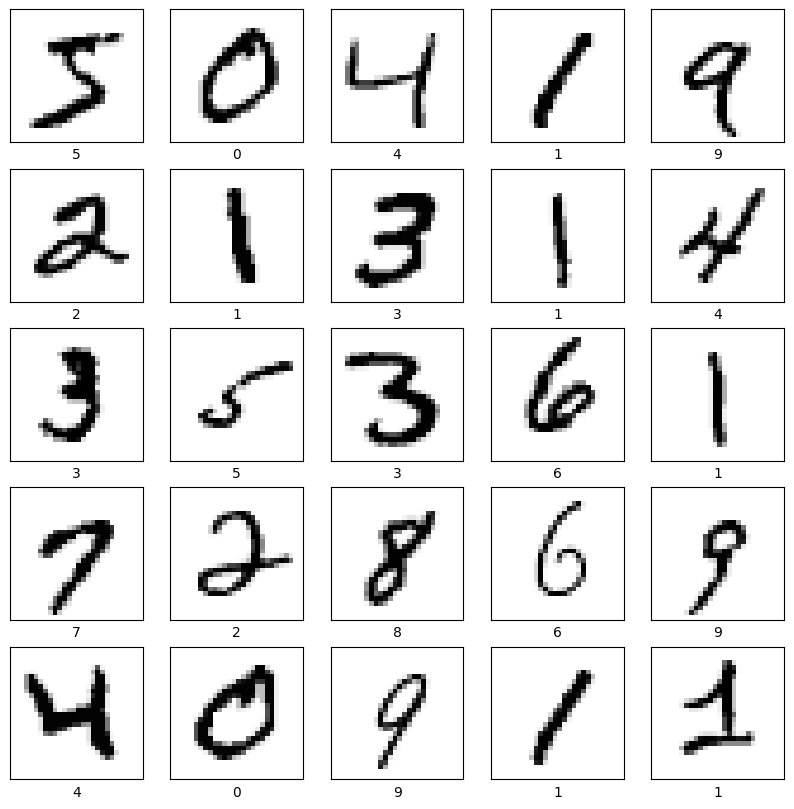

In [9]:
# Посмотрим побольше примеров.
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='Greys')
    plt.xlabel(y_train[i])
plt.show()

In [10]:
# Вытянем картинку в вектор размера 28*28=784 и будем использовать это как признаки.

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [11]:
# центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(np.float) / 255 - 0.5
x_val_float = x_val_flat.astype(np.float) / 255 - 0.5

# По сути, это действия аналогичны нормализации через StandardScaler.
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите что будет.
# x_train_float = x_train_flat.astype(np.float)
# x_val_float = x_val_flat.astype(np.float)

In [12]:
# Горячее кодирование для ответов.
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] [5 0 4 1 9]


# Собираем модель

Построим простой Multi layer Perceptron (MLP) классификатор в Keras (по аналогии со знакомым нам уже MLPClassifier из sklearn)

<img src="https://cdn-images-1.medium.com/max/1600/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png" width="500">

Сначала надо будет посчитать логиты (logit, линейное преобразование) $z_k$ для каждого класса: $$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

А затем превратить логиты $z_k$ в вероятности $p_k$ при помощи функции softmax: $$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

Мы будем использовать cross-entropy для минимизации ошибки: $$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$

где $$ [x]=\begin{cases} 1, \quad \text{если $x$ истина} \\ 0, \quad \text{иначе} \end{cases} $$

Минимизация cross-entropy двигает $p_k$ в сторону 1 когда $y = k$, что как раз мы и хотим.


In [13]:
# Для очистки памяти модели, чтобы она не доучивалась, а училась заново.
clear_session()

In [14]:
# Архитектура сети.
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax',)) # выходной слой

In [15]:
# Для просмотра архитектуры модели.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [17]:
# Обучаем модель.
history = model.fit(
                    x_train_float,
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/10
938/938 [==============================] - 11s 5ms/step - loss: 0.3579 - accuracy: 0.8908 - val_loss: 0.2305 - val_accuracy: 0.9243
Epoch 2/10
938/938 [==============================] - 3s 4ms/step - loss: 0.1639 - accuracy: 0.9504 - val_loss: 0.1262 - val_accuracy: 0.9614
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1218 - accuracy: 0.9613 - val_loss: 0.1115 - val_accuracy: 0.9646
Epoch 4/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0998 - accuracy: 0.9694 - val_loss: 0.1028 - val_accuracy: 0.9665
Epoch 5/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0834 - accuracy: 0.9739 - val_loss: 0.0970 - val_accuracy: 0.9686
Epoch 6/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0753 - accuracy: 0.9759 - val_loss: 0.0876 - val_accuracy: 0.9726
Epoch 7/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0646 - accuracy: 0.9801 - val_loss: 0.0810 - val_accuracy: 0.9765
Epoch

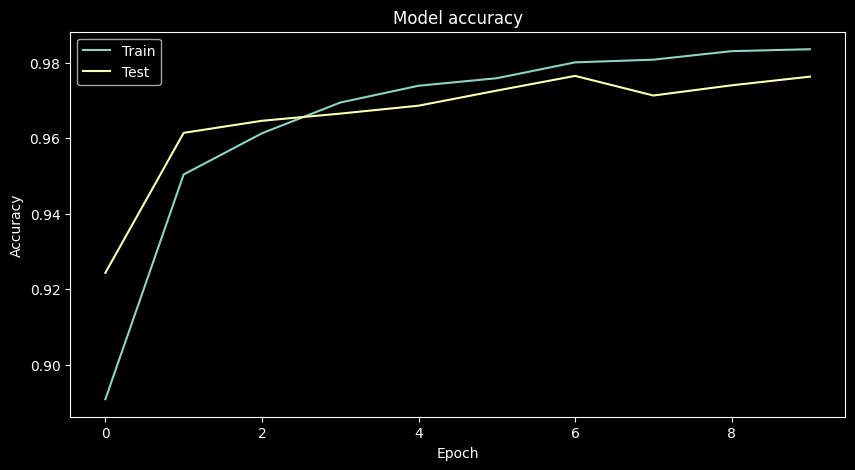

In [18]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

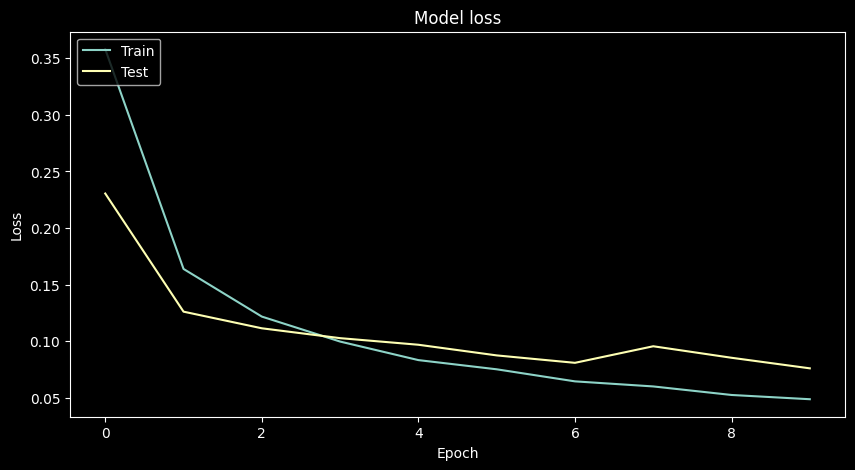

In [19]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
# Делаем предсказание.
model.predict(x_val_float)

313/313 [==============================] - 1s 2ms/step


array([[1.5190111e-07, 8.8430205e-09, 4.7466060e-06, ..., 9.9948031e-01,
        4.7571789e-06, 8.0923583e-06],
       [9.0150838e-09, 4.0408586e-06, 9.9999595e-01, ..., 1.0525152e-09,
        1.6903089e-08, 1.9971823e-16],
       [3.4800888e-08, 9.9986386e-01, 8.0009777e-05, ..., 1.8661298e-05,
        3.3752855e-05, 1.9149382e-09],
       ...,
       [3.3193949e-15, 4.7038107e-12, 4.1631678e-15, ..., 3.2486039e-08,
        1.3057604e-08, 8.0912840e-05],
       [4.7651881e-07, 1.0058046e-10, 5.5166861e-11, ..., 3.0727653e-11,
        1.0562821e-04, 1.3680089e-12],
       [1.0717799e-08, 2.5187415e-12, 3.2375707e-09, ..., 1.8438095e-15,
        3.0265368e-10, 1.0174699e-11]], dtype=float32)

In [21]:
# Предсказываем классы: определяем номер класса,
# для которого вероятность принадлежности максимальна.
np.argmax(model.predict(x_val_float), axis = 1)

313/313 [==============================] - 1s 2ms/step


array([7, 2, 1, ..., 4, 5, 6])

In [22]:
# Считаем метрику.
predicts = np.argmax(model.predict(x_val_float), axis = 1)
print('Test Accuracy:', accuracy_score(y_val, predicts))

313/313 [==============================] - 1s 2ms/step
Test Accuracy: 0.9763
